In [1]:
# Import
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import random
import cv2

Using TensorFlow backend.


In [3]:
!unzip /content/melspectogram_new_videos.zip

Streaming output truncated to the last 5000 lines.
  inflating: melspectogram_new_videos/THENUN_2313.png  
  inflating: melspectogram_new_videos/THENUN_2314.png  
  inflating: melspectogram_new_videos/THENUN_2315.png  
  inflating: melspectogram_new_videos/THENUN_2316.png  
  inflating: melspectogram_new_videos/THENUN_2317.png  
  inflating: melspectogram_new_videos/THENUN_2318.png  
  inflating: melspectogram_new_videos/THENUN_2319.png  
  inflating: melspectogram_new_videos/THENUN_232.png  
  inflating: melspectogram_new_videos/THENUN_2320.png  
  inflating: melspectogram_new_videos/THENUN_2321.png  
  inflating: melspectogram_new_videos/THENUN_2322.png  
  inflating: melspectogram_new_videos/THENUN_2323.png  
  inflating: melspectogram_new_videos/THENUN_2324.png  
  inflating: melspectogram_new_videos/THENUN_2325.png  
  inflating: melspectogram_new_videos/THENUN_2326.png  
  inflating: melspectogram_new_videos/THENUN_2327.png  
  inflating: melspectogram_new_videos/THENUN_2328.png 

In [0]:
import pandas as pd
df = pd.read_csv('/content/features.csv')

In [0]:
import os
import pandas as pd
newsize = (100, 100)
# get the images
files = os.listdir('/content/melspectogram_new_videos')
import pandas as pd
images =[]
lables = []
for file in files:
  x = df.loc[df['FileName'] == file[:-4]]
  lbl = x['isSubTitlePresent?'].values
  if lbl == 1:
    img = cv2.imread(('/content/melspectogram_new_videos/'+str(file)), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, newsize, interpolation = cv2.INTER_AREA)
    img = img.img_to_array(img)
    img = np.expand_dims(img, axis = 0)
    img= img.reshape(newsize)
    images.append(img)
    lables.append(lbl)

In [0]:
# construct the training and testing split
images = np.array(images)
lables = np.array(lables)
(x_train, x_test,y_train, y_test) = train_test_split(images,lables, test_size=0.1,random_state=42)

Training shape: (14134, 100, 100)
14134 sample, 100 x 100 size grayscale image.

Test shape: (1571, 100, 100)
1571 sample, 100 x 100 size grayscale image.

Examples:


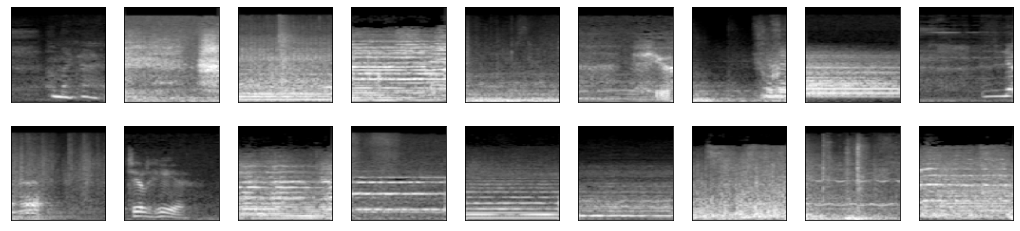

In [15]:
# About Dataset:
print('Training shape:', x_train.shape)
print(x_train.shape[0], 'sample,',x_train.shape[1] ,'x',x_train.shape[2] ,'size grayscale image.\n')
print('Test shape:', x_test.shape)
print(x_test.shape[0], 'sample,',x_test.shape[1] ,'x',x_test.shape[2] ,'size grayscale image.\n')

print('Examples:')
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_train[i].reshape(newsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(x_test[i].reshape(newsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [17]:
# Deep Learning Model:
from tensorflow.keras.layers import Conv2DTranspose,Input, Conv2D, MaxPooling2D, UpSampling2D, Dense
from tensorflow.keras.models import Model

input_img = Input(shape=(100, 100, 1))

x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)
# Output Shape: 4x4x8

x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x) #con2d transpose
#decoded = Conv2DTranspose(1, (3, 3), activation='sigmoid', padding='same')(x)
decoded= Conv2DTranspose(1, (3, 3), padding="same")(x)
# Output Shape: 28x28x1

autoencoder_simple = Model(input_img, decoded)
autoencoder_simple.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder_simple.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 16)      160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 50, 50, 8)         1160      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 25, 25, 8)         584       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 13, 13, 8)         0     

In [0]:
# Checkpoints:
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
checkpoints = []
checkpoints.append(TensorBoard(log_dir='/Checkpoints/logs'))

In [23]:
nb_epoch = 50
batch_size = 1000

autoencoder_simple.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

checkpointer = ModelCheckpoint(filepath="model.h5", verbose=0, save_best_only=True)
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True,write_images=True)

history = autoencoder_simple.fit(x_train, x_train, epochs=nb_epoch, batch_size=batch_size,shuffle=True, validation_data=(x_test, x_test),verbose=1,
                   callbacks=[checkpointer, tensorboard]).history

Epoch 1/50
15/15 [==============================] - 137s 9s/step - loss: 439.0391 - accuracy: 0.0570 - val_loss: 312.3292 - val_accuracy: 0.0617
Epoch 2/50
15/15 [==============================] - 134s 9s/step - loss: 200.8026 - accuracy: 0.0751 - val_loss: 158.8308 - val_accuracy: 0.0737
Epoch 3/50
15/15 [==============================] - 134s 9s/step - loss: 159.0917 - accuracy: 0.0756 - val_loss: 143.7523 - val_accuracy: 0.0746
Epoch 4/50
15/15 [==============================] - 134s 9s/step - loss: 145.8982 - accuracy: 0.0700 - val_loss: 141.3232 - val_accuracy: 0.0795
Epoch 5/50
15/15 [==============================] - 134s 9s/step - loss: 142.0730 - accuracy: 0.0740 - val_loss: 139.9320 - val_accuracy: 0.0729
Epoch 6/50
15/15 [==============================] - 136s 9s/step - loss: 140.6059 - accuracy: 0.0741 - val_loss: 139.0366 - val_accuracy: 0.0732
Epoch 7/50
15/15 [==============================] - 134s 9s/step - loss: 139.6830 - accuracy: 0.0731 - val_loss: 138.7467 - val_ac

In [0]:
#use either autoencoder_simple ot autoencoder_complex
decoded_imgs_smpl = autoencoder_simple.predict(x_test)

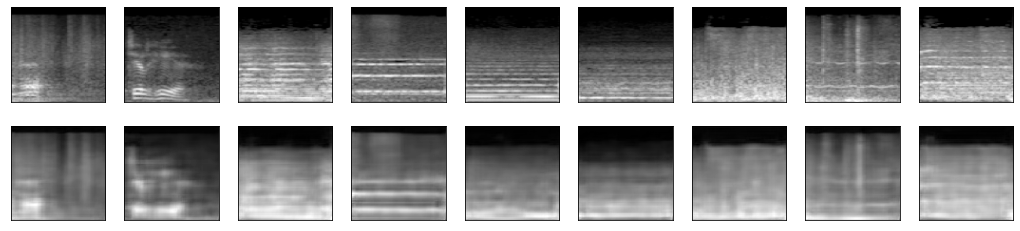

In [21]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(1, n):
    # display original
    ax = plt.subplot(2, n, i)
    plt.imshow(x_test[i].reshape(newsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    plt.imshow(decoded_imgs_smpl[i].reshape(newsize))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)


Classification

In [0]:
errors = []
for (x, decoded_img) in zip(x_test, decoded_imgs):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((x - decoded_img) ** 2)
	errors.append(mse)

In [32]:
thresh = np.quantile(errors, 0.70)
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 3178.386206054687
[INFO] 60 outliers found


In [33]:
print(np.count_nonzero(y_test == 1))

200


In [34]:
#y_pred = y_test
n = 0
y_pred = np.full(y_test.shape, 1) #true class
for id in idxs:
  y_pred[id] = 0 #anomoly class
  if y_test[id] != 0:
    n = n +1
print(n)

60
